### TODO:
- Bayesian opt for hyperparameter selection.
- Look at where model is getting things wrong. Make function that plots largest/pathological errors.
- Look at LBM paper for error.

### Done/dismissed:
- Try demeaning all series? - doesn't work well.
- Why do plots have such different proportions of houses? - because three homes have data for *all* time periods.
- Changed kettle on_power_threshold to 1500 (from 2000) since it wasn't catching activations for house 3.
- Figure out why house 3/5/20 has inverse fridge pattern. - not sure but can look into it later

In [1]:
from __future__ import division

from utils import *
from create_data import *
from build_models import *

import os
import sys
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime, date, timedelta
from dateutil.parser import parse
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# from ggplot import *

import keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, LambdaCallback
from keras.utils import plot_model
from keras import regularizers

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_for_model = os.path.join(dir_data, 'for_model')
dir_for_model_real = os.path.join(dir_for_model, 'real')
dir_for_model_synth = os.path.join(dir_for_model, 'synthetic')
dir_models = os.path.join(dir_data, 'models')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))
path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')

In [3]:
N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS = range(1, 22); HOUSE_IDS.remove(14)  # no house 14
HOUSE_IDS_TEST = [2,9,20]
HOUSE_IDS_TRAIN_VAL = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_TEST]
# HOUSE_IDS_SOLAR = [3,11,21]  # according to paper
HOUSE_IDS_SOLAR = [1,11,21]  # according to inspection
HOUSE_IDS_NOT_SOLAR = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_SOLAR]
# TRAIN_VAL_DATE_MAX = date(2015,2,28)
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
TRAIN_DTS = np.load(os.path.join(dir_for_model_synth, 'train_dts.npy'))

In [4]:
take_diff = False
# val_prop = 0.2
train_dates = [dt.date() for dt in TRAIN_DTS]
extreme_percentile_cutoff = 100

In [5]:
# In every set of data, there's a feature set X, targets Y, and extra features
# regarding house number and date that can be used to subset or diagnose.
# This data will be saved as a package according to the order below. This makes
# it easier to enter into functions like train_test_split() and shuffle() using
# *kwargs.
X_idx, Y1_idx, Y2_idx, x_house_idx, x_date_idx = range(5)
Y_energy_idx = Y1_idx
Y_activations_idx = Y2_idx

Run this once

In [6]:
np.random.seed(20170627)

dstats = pd.read_pickle(path_daily_stats)
dstats = clean_daily_stats(dstats, is_debug=False)

all_data = prepare_real_data(dir_for_model_real,
                             dstats,
                             extreme_percentile_cutoff,
                             HOUSE_IDS_SOLAR,
                             HOUSE_IDS_TRAIN_VAL,
                             train_dates,
                             X_idx, Y1_idx, Y2_idx, x_house_idx, x_date_idx)

all_data = prepare_synth_data(dir_for_model_synth,
                              extreme_percentile_cutoff,
                              X_idx, Y1_idx, Y2_idx, x_house_idx, x_date_idx,
                              all_data = all_data)

# Want to take diffs before making scalers.
if take_diff:
    print 'taking diffs...'
    for key in all_data.keys():
        all_data[key][X_idx] = take_diff_df(all_data[key][X_idx])

print 'creating scalers...'
scaler_real, scaler_synth, scaler_both = create_scalers_for_real_synth_both(all_data, X_idx)

print 'scaling validation and test data...'
for split_type in ['val', 'test']:
    all_data[split_type][X_idx] = scaler_real.transform(all_data[split_type][X_idx])
    all_data[split_type][X_idx] = scaler_both.transform(all_data[split_type][X_idx])

processing real data...
removing extreme values...
removing homes with solar panels...
remove obs where correlation between main and sum of apps is low
removed 15 obs (0.21% of total)
remove obs where agg value is repeated
removed 86 obs (1.2% of total)
splitting into training, validation and test data...
real obs for training: 4960 (71% of total)
datasets: ['real_train', 'val', 'test']
loading synthetic data...
removing extreme values...
datasets: ['real_train', 'val', 'test', 'synth_train_all']
creating scalers...


/Users/sipola/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


scaling validation and test data...


In [7]:
# Extract val/test data for easy reference.
val_data = list(all_data['val'])
test_data = list(all_data['test'])

Now that the data's set up, choose what you want to model.

In [12]:
# Get index of type of variable to model and appliance to model.
target_type = 'activations'  # 'energy' or 'activations'
app_names = ['washing machine']
batch_size = 32
real_to_synth_ratio = 0.5
modeling_group_name = str(date.today())
continue_from_last_run = True
models_to_run = 1
epochs = 100
total_obs_per_epoch = 8192
# total_obs_per_epoch = 256

steps_per_epoch = total_obs_per_epoch // batch_size
dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))

Y_idx = Y_energy_idx if target_type=='energy' else Y_activations_idx

app_idx = []
for app_name in app_names:
    app_idx.append(APP_NAMES.index(app_name))
    

target_scaler = StandardScaler().fit(
    np.concatenate((all_data['synth_train_all'][Y_idx][:,app_idx],
                    all_data['real_train'][Y_idx][:,app_idx])))

generator = generate_data((all_data['real_train'][X_idx], all_data['real_train'][Y_idx][:,app_idx]),
                          (all_data['synth_train_all'][X_idx], all_data['synth_train_all'][Y_idx][:,app_idx]),
                          scaler_real, scaler_synth, scaler_both, target_scaler,
                          batch_size = batch_size,
                          real_to_synth_ratio = real_to_synth_ratio)

# "Append" results to last runs of models, if they exist?
max_model_num = get_max_model_num(continue_from_last_run, dir_models_set)

for model_num in np.arange(models_to_run) + max_model_num:
    
    # model_name = 'model_{}'.format(model_num)
    model_name = 'simple_small'
    print '='*25 + '\n{}\n'.format(model_name) + '='*25

    params = {
        'num_conv_layers': 3,
        'num_dense_layers': 2,
        'start_filters': 8,
        'deepen_filters': True,
        'kernel_size': 6,
        'strides': 2,
        'dilation_rate': 1,
        'do_pool': True,
        'pool_size': 2,
        'last_dense_layer_size': 32,
        'dropout_rate_after_conv': 0.25,
        'dropout_rate_after_dense': 0.5,
        'use_batch_norm': False,
        'optimizer': keras.optimizers.Adam,
        'learning_rate': 0.0001,
        'l2_penalty': 0
    }
    
    # params = {
    #     'num_conv_layers': 6,
    #     'num_dense_layers': 2,
    #     'start_filters': 8,
    #     'deepen_filters': True,
    #     'kernel_size': 6,
    #     'strides': 2,
    #     'dilation_rate': 1,
    #     'do_pool': True,
    #     'pool_size': 2,
    #     'last_dense_layer_size': 16,
    #     'dropout_rate_after_conv': 0.25,
    #     'dropout_rate_after_dense': 0.5,
    #     'use_batch_norm': False,
    #     'optimizer': keras.optimizers.Adam,
    #     'learning_rate': 0.0003,
    #     'l2_penalty': 0
    # }
    # params = random_params()

    print pd.DataFrame.from_dict(params, orient='index')
    print '\n' + '='*25 + '\n'

    output_layer_activation = 'relu' if target_type=='energy' else 'relu'  #########################
    model = create_model(len(app_names), output_layer_activation, N_PER_DAY, **params)

    dir_this_model = os.path.join(dir_models_set, model_name)
    model_filename = os.path.join(dir_this_model, 'weights.hdf5')
    history_filename = os.path.join(dir_this_model, 'history.csv')
    params_filename = os.path.join(dir_this_model, 'params.csv')
    makedirs2(dir_this_model)

    pd.DataFrame.from_dict(params, orient='index').to_csv(params_filename, header=False)

    # Define callbacks
    # https://keras.io/callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    csvlogger = CSVLogger(history_filename, separator=',', append=False)
    checkpointer = ModelCheckpoint(filepath=model_filename, verbose=1, save_best_only=True)
    runtime_history = RuntimeHistory()

    history = model.fit_generator(generator,
                                  steps_per_epoch = steps_per_epoch,
                                  epochs = epochs,
                                  validation_data=(reshape_as_tensor(all_data['val'][X_idx]),
                                                   all_data['val'][Y_idx][:,app_idx]),
                                  callbacks = [early_stopping, csvlogger, checkpointer, runtime_history],
                                  verbose = 0)

    # Add runtimes to CSV.
    history_df = pd.read_csv(history_filename)
    history_df['runtime'] = runtime_history.runtime
    history_df.to_csv(history_filename, index=False)

    # Load best model.
    model_filename = os.path.join(dir_this_model, 'weights.hdf5')
    model = load_model(model_filename)

    plot_errors(history_df)
    plt.show()

simple_small
                                                        0
optimizer                 <class 'keras.optimizers.Adam'>
num_dense_layers                                        2
do_pool                                              True
num_conv_layers                                         5
learning_rate                                      0.0001
last_dense_layer_size                                  32
deepen_filters                                       True
dropout_rate_after_dense                              0.5
pool_size                                               2
strides                                                 1
dilation_rate                                           1
start_filters                                           8
use_batch_norm                                      False
l2_penalty                                              0
dropout_rate_after_conv                              0.25
kernel_size                                             3



/Users/sipola/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Epoch 00000: val_loss improved from inf to 1.08888, saving model to /Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis/data/models/2017-07-01/activations/washingmachine/simple_small/weights.hdf5


KeyboardInterrupt: 

In [117]:
model.evaluate(*(reshape_as_tensor(all_data['val'][X_idx]),
                 all_data['val'][Y_idx][:,app_idx]))

 992/1009 [============================>.] - ETA: 0s

741.00198234202719

In [34]:
modeling_group_name = 'after_data_clean'
target_type = 'energy'
app_names = ['washing machine']
# app_names = list(APP_NAMES)

Y_idx = Y_energy_idx if target_type=='energy' else Y_activations_idx

app_idx = []
for app_name in app_names:
    app_idx.append(APP_NAMES.index(app_name))

dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
model_files = get_model_files(dir_models_set)

history_all = []
params_all = []

for model_name in model_files:
    
    history_df = pd.read_csv(os.path.join(dir_models_set, model_name, 'history.csv'))
    params_df = pd.read_csv(os.path.join(dir_models_set, model_name, 'params.csv'),
                            header=None,
                            names=['param', 'value'])
    
    history_df['model'] = model_name
    params_df['model'] = model_name    
    
    history_all.append(history_df)
    params_all.append(params_df)
    
    # print model_name
    # print params_df

    # plot_errors(history_df, figsize=(11,5))
    # plt.show()
    
params_all = pd.concat(params_all)
history_all = pd.concat(history_all)

# print all_history
params_wide = params_all.pivot(index='model', columns='param')
history_best = history_all.groupby('model').agg({
    'loss': min,
    'val_loss': min,
    'runtime': min
    'epoch': len
})

hist_and_params = history_best.join(params_wide)

hist_and_params.sort_values('val_loss', inplace=True)
# hist_and_params.to_csv('tmp.csv')

hist_and_params
# print params_all

/Users/sipola/miniconda2/lib/python2.7/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,loss,epoch,runtime,val_loss,"(value, deepen_filters)","(value, dilation_rate)","(value, do_pool)","(value, dropout_rate_after_conv)","(value, dropout_rate_after_dense)","(value, kernel_size)","(value, l2_penalty)","(value, last_dense_layer_size)","(value, learning_rate)","(value, num_conv_layers)","(value, num_dense_layers)","(value, optimizer)","(value, pool_size)","(value, start_filters)","(value, strides)","(value, use_batch_norm)"
model,,,,,,,,,,,,,,,,,,,,
first_run_after_data_clean_with_relu,0.130284,43,22.797965,0.166634,True,1,True,0.25,0.5,6,0,16,0.0003,3,2,<class 'keras.optimizers.Adam'>,2,4,2,False
first_run_after_data_clean,0.146567,32,22.701556,0.188108,True,1,True,0.25,0.5,6,0,16,0.0003,3,2,<class 'keras.optimizers.Adam'>,2,4,2,False


In [42]:
# Load best model
best_model_name = hist_and_params.loc[hist_and_params['loss']==hist_and_params['loss'].min()].index.values[0]
model = load_model(os.path.join(dir_models_set, best_model_name, 'weights.hdf5'))
# model = load_model('/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis/data/models/2017-06-28/fridge/model_11/weights.hdf5')

In [119]:
# app_idx2 = 2
# app_idx2 = list(app_idx)
sub_app_idx = 0
if len(app_idx) == 1:
    sub_app_idx = 0
y_val = val_data[Y_idx][:,app_idx][:,sub_app_idx]
y_hat = model.predict(reshape_as_tensor(val_data[X_idx]))[:,sub_app_idx]
if all(y_hat[0] == y_hat):
    print 'all predicted values are the same!'

In [85]:
# plot_series(val_data[X_idx][1])

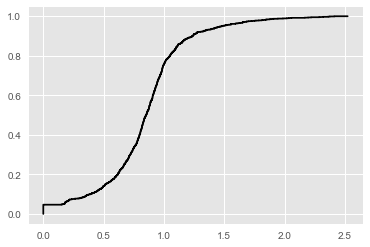

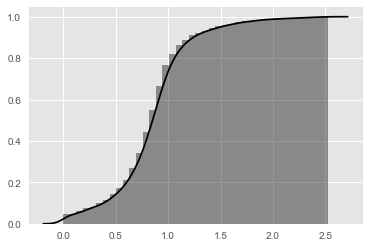

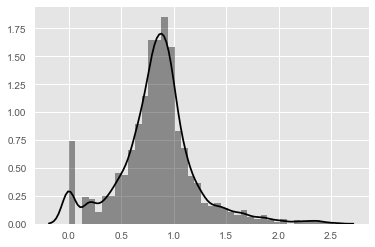

In [98]:
# sns.distplot(np.log2(y+1))
# sns.distplot(y, color='black')
plot_empir_cum(y_val)
plt.show()
sns.distplot(y_val, color='black', hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
plt.show()
sns.distplot(y_val, color='black')
plt.show()

# for i in range(Y.shape[1]):
#     ax = sns.distplot(Y[:,i], color='black')
#     ax.set_title('{}, actual'.format(APP_NAMES[i]))
#     plt.show()
#     ax = sns.distplot(Y_hat[:,i], color='black')
#     ax.set_title('{}, predicted'.format(APP_NAMES[i]))
#     plt.show() 

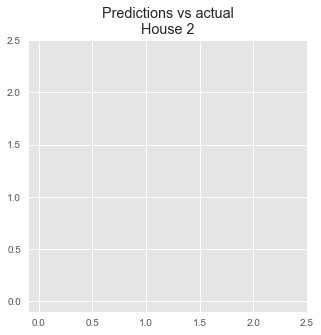

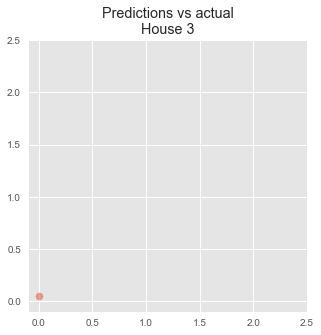

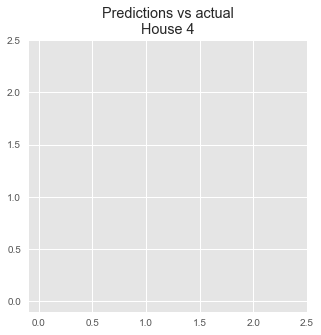

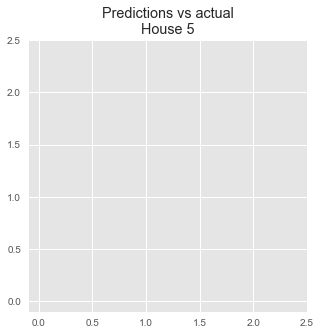

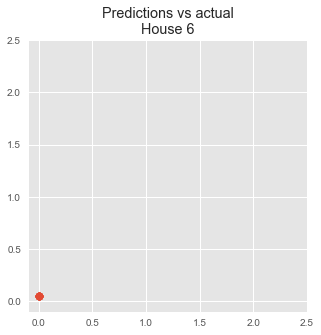

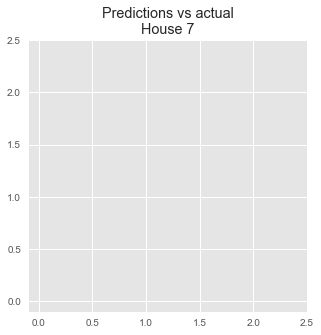

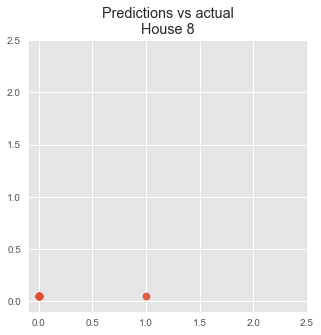

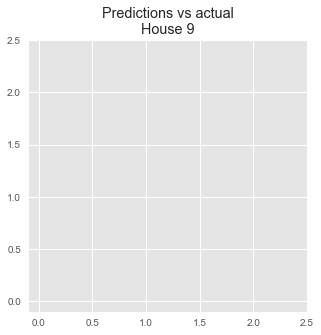

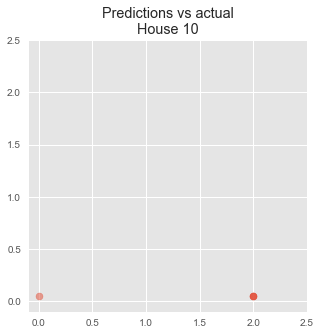

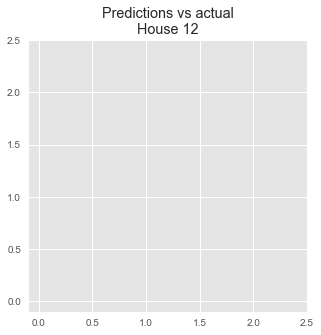

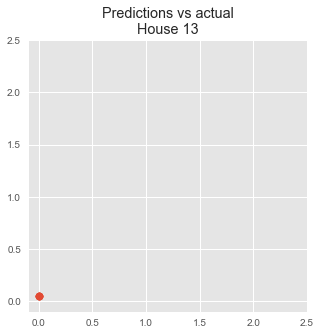

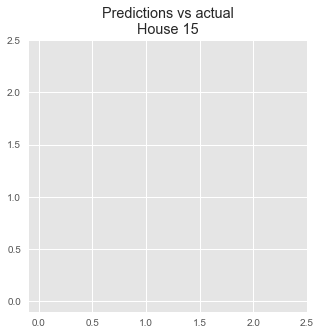

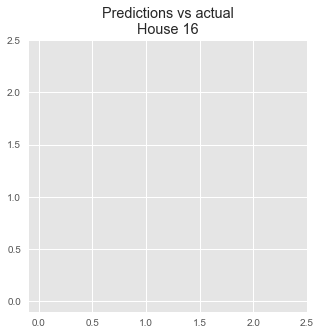

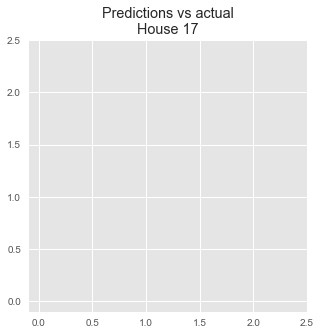

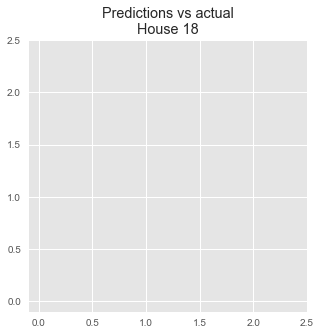

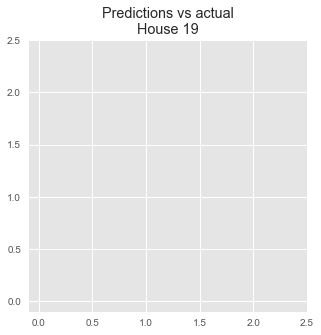

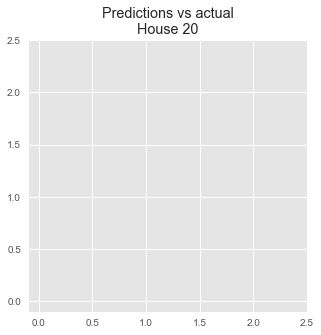

In [120]:
# # y_hat = dist_fun(y_hat, min_y, True)
# ax = sns.regplot(x=array_to_1d(y), y=array_to_1d(y_hat), color='black')
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)

# colormap = plt.cm.Set1

x_house_val = val_data[x_house_idx]

plot_together = False
figsize = (5,5)
plt_title = 'Predictions vs actual'
if plot_together:
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, title=plt_title)
# ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, len(app_names))])
for house_id in list(set(x_house_val)):
    if not plot_together:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, title=plt_title + '\nHouse {}'.format(house_id))
        ax.set_ylim(-0.1,2.5)
        ax.set_xlim(-0.1,2.5)
    y_hat_house = y_hat[x_house_val==house_id]
    y_val_house = y_val[x_house_val==house_id]
    ax.scatter(y_val_house, y_hat_house, alpha=0.5, label=house_id)
# plt.show()
# ax.set_ylim(0,2.5)
# ax.set_xlim(0,2.5)
if plot_together:
    ax.legend()
plt.show()
# print min(y_hat)


# i = 3
# y, y_hat = Y[:,i], Y_hat[:,i]
# fig = plt.figure()
# ax = fig.add_subplot(111, title='Test scatter')
# ax.scatter(y_hat, y, color='black', alpha=0.5)
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)
# # print min(y_hat)

num extreme predictions: 4
extreme prediction 0
actual energy: [ 0.395835], predicted: [ 11.80590725]


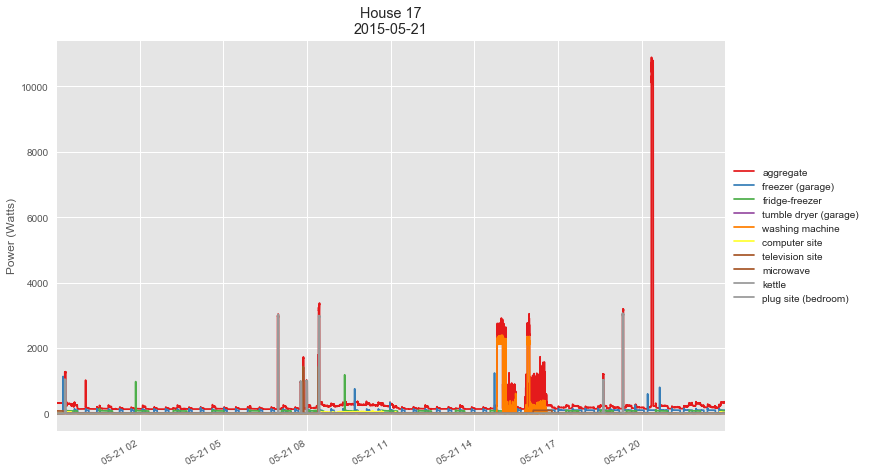

In [120]:
# Check where targets were normal but predictions were extreme.
extreme_y_hat_cutoff = 10

bad_idx = np.where(y_hat > extreme_y_hat_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 0  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

num extreme predictions: 2
extreme prediction 1
actual energy: [ 14.247415], predicted: [ 0.66881663]


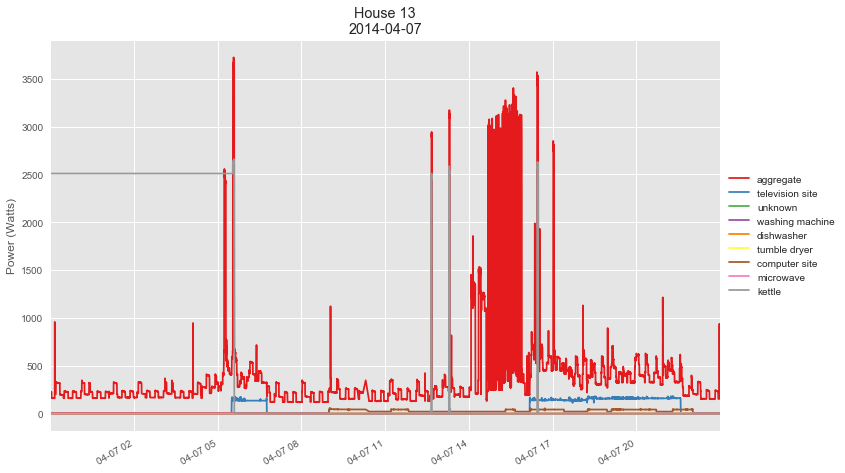

In [125]:
# Check where targets were extreme but predictions were too low.
extreme_y_cutoff = 2

bad_idx = np.where(y_val > extreme_y_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 1  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [ ]:
dir_refit_csv = os.path.join(dir_data, 'CLEAN_REFIT_081116')
dir_refit = os.path.join(dir_data, 'refit')
apps = pd.read_csv(os.path.join(dir_data, 'appliances.csv'))
app_dict = create_app_dict()
apps = apps_add_cols_from_patterns(apps, app_dict)
get_house_app_tuples, get_app_nums, get_app_name, is_a_target_app = create_app_funs(apps, app_dict, APP_NAMES)
load_app, load_ts, load_issues = create_load_funs(dir_refit)

path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')
dstats = pd.read_pickle(path_daily_stats)
dstats = clean_daily_stats(dstats)

def get_df(house_id, use_app_names=False, dt_start=None, dt_end=None, include_issues=False):
    '''
    Plot time series of power data for each appliance, for specified house and date(time).
    '''
    
    # Load time series for house and get timestamps for specified date.
    ts_series = load_ts(house_id)
    
    # Add first column to df (timestamp).
    df = pd.DataFrame({'Unix': ts_series})
    
    # Add appliance columns.
    for app_num in range(10):
        if use_app_names:
            app_name = get_app_name(house_id, app_num)
        else:
            app_name = 'Appliance{}'.format(app_num) if app_num>0 else 'Aggregate'
        df[app_name] = load_app(house_id, app_num)
        
    if dt_start is not None:  # that is, if we don't want all dates
        ts_mask = get_ts_mask(ts_series, dt_start, dt_end)
        df = df.loc[ts_mask]
    
    if include_issues:
        # Add issues column.
        df['Issues'] = load_issues(house_id)
    
    return df


def plot_day(house_id, dt, savefile=None, figsize=(9,5), cols=None):
    '''
    Plot time series of power data for each appliance, for specified house and date(time).
    '''
    df = get_df(house_id, use_app_names=True, dt_start=dt)
    if cols is not None:
        cols += ['Unix']  # add Unix in case it wasn't included in cols
        cols = list(set(cols))
        df = df[cols]
    df['Time'] = pd.to_datetime(df['Unix'], unit='s', utc=True)
    df.set_index('Time', inplace=True)
    del df['Unix']
    
    # df = df.tz_localize('GMT').tz_convert('Europe/London')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    app_names = list(df)  # get columns from DataFrame
   
    # Set color map.
    colormap = plt.cm.Set1
    ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, len(app_names))])
    # ax = df.plot(figsize=figsize)
    for app_name in app_names:
        ax = df[app_name].plot(figsize=figsize)
    ax.set_title('House {}\n{}'.format(house_id, dt.date().strftime('%Y-%m-%d')))
    ax.set_xlabel('')
    ax.set_ylabel('Power (Watts)')
    # plt.xticks(np.arange(min(df.index), max(df.index)+1, 8.))

    # Put legend outside of plot.
    # https://stackoverflow.com/a/4701285/4794432
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # # Decrese legend font size.
    # fontP = FontProperties()
    # fontP.set_size('xx-small')

    if savefile is not None:
        plt.savefig(savefile)
    return ax

In [14]:
# val_data[X_idx][0]
i = 21
app_name = 'washing machine'

app_idx = APP_NAMES.index(app_name)

plot_series(val_data[X_idx][i])
house_id = val_data[x_house_idx][i]
d = val_data[x_date_idx][i]
energy1 = val_data[Y_idx][i][app_idx]
print house_id, d, energy1

plot_day(house_id, date_to_datetime(d))
energy2 = get_energy(dstats, house_id, d, get_app_nums(house_id, app_name))
print energy2

NameError: name 'val_data' is not defined